# Final Solution

In [4]:
# This seed is used in all models
SEED = 42

### Initializing Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark Session
spark = SparkSession.builder.appName("MovieLensALS").getOrCreate()

# Load data
data_path = "../data/interim/"
ratings = spark.read.parquet(data_path + "ratings_train.parquet", sep='\t', inferSchema=True)
ratings = ratings.withColumnRenamed("_c0", "user_id") \
                 .withColumnRenamed("_c1", "movie_id") \
                 .withColumnRenamed("_c2", "rating")

test = spark.read.parquet(data_path + "ratings_test.parquet", sep='\t', inferSchema=True)
test = test.withColumnRenamed("_c0", "user_id") \
                 .withColumnRenamed("_c1", "movie_id") \
                 .withColumnRenamed("_c2", "rating")

### Creating ALS and forming a param grid for grid search

In [5]:
als = ALS(
    maxIter=50,
    userCol="user_id",
    itemCol="movie_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    seed=SEED
)

# I've chosen the following hyperparameters because they influence the result the most.
paramGrid = (
    ParamGridBuilder()
    .addGrid(als.rank, [10, 20, 30, 35, 40, 50])
    .addGrid(als.regParam, [0.01, 0.025, 0.05, 0.1, 0.14, 0.15])
    .build()
)

In [6]:
rmse_evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction"
)

crossval = CrossValidator(
    estimator=als, estimatorParamMaps=paramGrid, evaluator=rmse_evaluator, numFolds=3
)


cvModel = crossval.fit(ratings)

bestModel = cvModel.bestModel

# Print best rank and regParam
print("Best Rank:", bestModel._java_obj.parent().getRank())
print("Best regParam:", bestModel._java_obj.parent().getRegParam())
# Best Rank: 50
# Best regParam: 0.14

23/12/04 01:46:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/04 01:46:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


### Evaluating the acquired hyperparameters

In [7]:
mae_evaluator = RegressionEvaluator(
    metricName="mae", labelCol="rating", predictionCol="prediction"
)

predictions = bestModel.transform(test)

rmse_als = rmse_evaluator.evaluate(predictions)
mae_als = mae_evaluator.evaluate(predictions)
print("RMSE = " + str(rmse_als))
print("MAE = " + str(mae_als))
# RMSE = 0.9241108498697321
# MAE = 0.7382249872480782

RMSE = 0.9246741242184744
MAE = 0.738546007779988


### Importing the data for the Random Forest approach

In [8]:
import pandas as pd

# Load user data
data_path = "../data/interim/"

ratings_df_train = pd.read_parquet(data_path + "ratings_train.parquet")
ratings_df_test = pd.read_parquet(data_path + "ratings_test.parquet")
users_df = pd.read_parquet(data_path + "users.parquet")

combined_df_train = pd.merge(ratings_df_train, users_df, on="user_id")
combined_df_test = pd.merge(ratings_df_test, users_df, on="user_id")

labels_train = combined_df_train["rating"]
labels_test = combined_df_test["rating"]
combined_df_train.drop(["rating"], axis=1, inplace=True)
combined_df_test.drop(["rating"], axis=1, inplace=True)

### Initializing the model and param grid for grid search

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [112]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                           param_grid=param_grid,
                           cv=3,  # Number of folds for cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

# Fit the grid search to the data
grid_search.fit(combined_df_train, labels_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  13.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  14.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  14.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END m

/Users/random/miniconda3/envs/pmldl2/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  11.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  10.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  18.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  15.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  15.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  15.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

### Evaluating best parameters

In [15]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf = grid_search.best_estimator_

# Re-evaluate with the best parameters
rf_predictions = best_rf.predict(combined_df_test)

# Calculate accuracy, RMSE, and MAE
accuracy = accuracy_score(labels_test, rf_predictions)
rmse = mean_squared_error(labels_test, rf_predictions, squared=False)
mae = mean_absolute_error(labels_test, rf_predictions)

print(f"Best Model RMSE: {rmse}")
print(f"Best Model MAE: {mae}")
print(f"Best Model Accuracy: {accuracy}")

Best Model RMSE: 1.16586877477699
Best Model MAE: 0.83625
Best Model Accuracy: 0.37475


### Saving the models for later inference

In [150]:
import joblib

joblib.dump(best_rf, "./random_forest.joblib")
bestModel.write().save("als")

### Exporting the result data to pandas

In [16]:
als_predictions_selected = predictions.select('user_id', 'movie_id', 'prediction')
als_predictions_pandas = als_predictions_selected.toPandas()

als_predictions_pandas.head()
rf_predictions_df = pd.DataFrame({
    'user_id': ratings_df_test['user_id'],
    'movie_id': ratings_df_test['movie_id'],
    'prediction_rf': rf_predictions
})
combined_predictions = pd.merge(als_predictions_pandas, rf_predictions_df, on=['user_id', 'movie_id'])
final_evaluation_df = pd.merge(combined_predictions, ratings_df_test, on=['user_id', 'movie_id'])

### Running Linear Regression to find the best parameters for combining two recommendation approaches

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Your features are the predictions from ALS and Random Forest
X = final_evaluation_df[["prediction", "prediction_rf"]]

# The target variable is the actual rating
y = final_evaluation_df["rating"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test)

# Extracting coefficients
coefficients = lr_model.coef_
als_weight = coefficients[0]
rf_weight = coefficients[1]

print(f"Weight for ALS predictions: {als_weight}")
print(f"Weight for Random Forest predictions: {rf_weight}")

Weight for ALS predictions: 1.0040222071434484
Weight for Random Forest predictions: 0.03191595892962192


### Combining and printing the final results

In [46]:
combined_predictions['final_prediction'] = (combined_predictions['prediction'] * als_weight + combined_predictions['prediction_rf'] * rf_weight)
final_evaluation_df = pd.merge(combined_predictions, ratings_df_test, on=['user_id', 'movie_id'])
final_evaluation_df

,user_id,movie_id,prediction,prediction_rf,final_prediction,rating
0,251,148,3.216730,4,3.357332,2
1,255,833,2.364159,3,2.469417,4
2,321,496,3.912316,4,4.055716,4
3,108,471,3.236889,4,3.377572,2
4,101,471,3.231595,4,3.372257,3
...,...,...,...,...,...,...
19963,215,89,4.104869,4,4.249044,4
19964,144,89,3.935401,4,4.078894,3
19965,18,89,4.089432,4,4.233544,3
19966,138,517,3.913427,4,4.056832,4


In [47]:
# Calculate RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

final_rmse = mean_squared_error(final_evaluation_df['rating'], final_evaluation_df['final_prediction'], squared=False)
final_mae = mean_absolute_error(final_evaluation_df['rating'], final_evaluation_df['final_prediction'])

print(f'Final Combined RMSE: {final_rmse}')
print(f'Final Combined MAE: {final_mae}')

Final Combined RMSE: 0.9112483873060725
Final Combined MAE: 0.7186316111492439


### Visualizations!

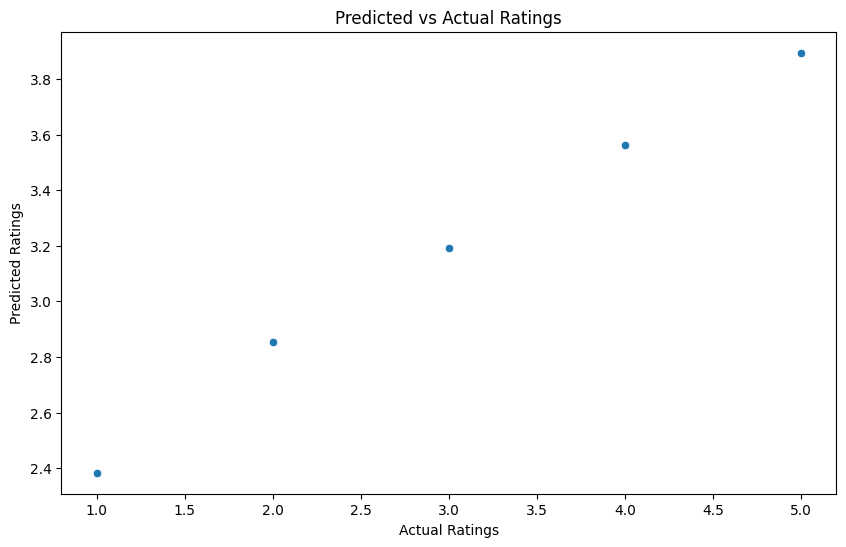

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by actual rating and calculate the mean of predicted ratings
average_predictions = final_evaluation_df.groupby('rating')['prediction'].mean().reset_index()

# Plotting the actual vs. predicted ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x="rating", y="prediction", data=average_predictions)

plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

As we can see, the model captures (on average) how good a film is pretty well.

### Showing how RMSE and MAE decreased when the hybrid approach was implemented.

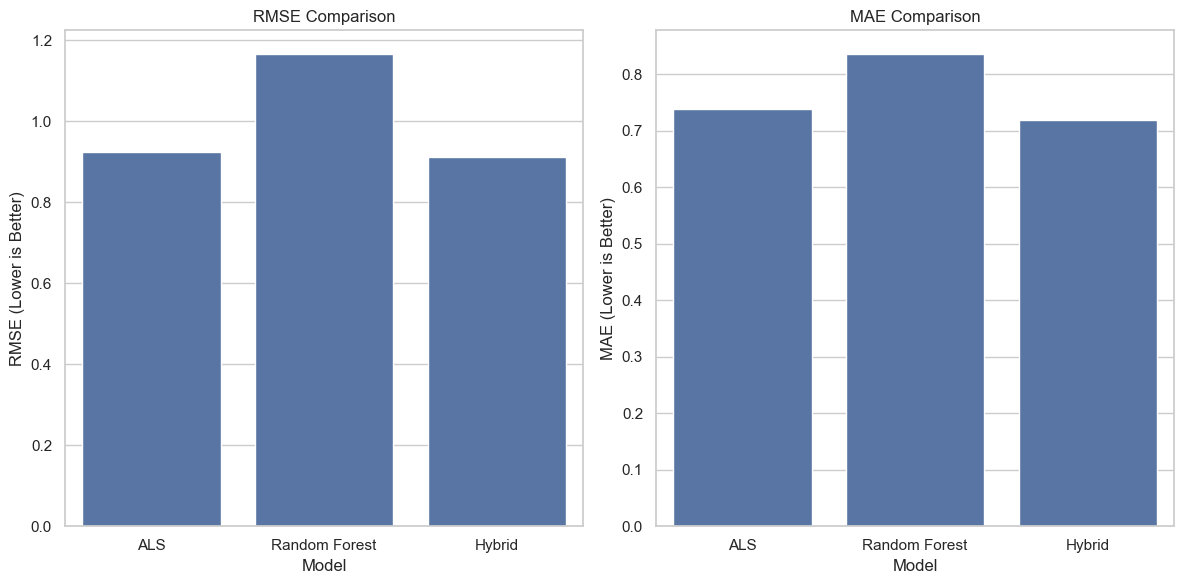

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "Model": ["ALS", "Random Forest", "Hybrid"],
    "RMSE": [rmse_als, rmse, final_rmse],
    "MAE": [mae_als, mae, final_mae],
}

metrics_df = pd.DataFrame(data)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot RMSE
sns.barplot(x="Model", y="RMSE", data=metrics_df, ax=axes[0])
axes[0].set_title("RMSE Comparison")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("RMSE (Lower is Better)")

# Plot MAE
sns.barplot(x="Model", y="MAE", data=metrics_df, ax=axes[1])
axes[1].set_title("MAE Comparison")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("MAE (Lower is Better)")

plt.tight_layout()
plt.show()

As we can see, the RMSE of the hybrid model slightly decreased compared to ALS. Also, there was a somewhat significant jump in MAE when a Hybrid approach was introduced compared to ALS, so the hassle of making the model hybrid was worth it!

### Recommendation function

In [66]:
def recommend_movies(df, user_id, top_n=10):
    """
    Recommend top N movies for a given user.

    Parameters:
    df (DataFrame): The DataFrame containing the ratings and predictions.
    user_id (int): The user ID for whom recommendations are to be made.
    top_n (int): The number of top recommendations to return.

    Returns:
    list: List of recommended movie IDs.
    """
    # Filter for the specific user
    user_df = df[df['user_id'] == user_id]

    # Sort by 'final_prediction' in descending order
    sorted_user_df = user_df.sort_values(by='final_prediction', ascending=False)
    
    # Select top N movies
    top_movies = sorted_user_df.head(top_n)

    # Extract movie IDs
    recommended_movies = top_movies['movie_id'].tolist()

    return recommended_movies


user_id = 12 # Replace with the user ID you want to get recommendations for
recommended_movies = recommend_movies(final_evaluation_df, user_id, top_n=5)
print(recommended_movies)

[318, 50, 172, 96, 191]
